In [5]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
import numpy as np
# import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
path = '../Dataset/Embedding/'
outputFilename = 'BoostingOutput.csv'

## With Word Embedding (BoW) Dataset

In [21]:
X = pd.read_csv(path+'kolkata_WE_100.csv')
Y = pd.read_csv(path+'kolkata_classLabel.csv')
print(X.shape,Y.shape)

(8329, 100) (8329, 1)


In [26]:
change = {}
change[-1]=5
Y = Y.replace(change)
Y

,label
0,3
1,1
2,3
3,1
4,3
...,...
8324,1
8325,0
8326,1
8327,2


In [16]:
Y.label.value_counts()

 0    2150
 1    1811
 3    1636
 2    1375
-1    1103
 4     254
Name: label, dtype: int64

In [27]:
Y.label.value_counts()

0    2150
1    1811
3    1636
2    1375
5    1103
4     254
Name: label, dtype: int64

In [28]:
labels = Y.label.unique()
labels.sort()
labels

array([0, 1, 2, 3, 4, 5])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['label'])
print(X_train.shape, X_test.shape)

(6246, 100) (2083, 100)


In [30]:
model = XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [31]:
y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
pred_proba

array([[4.3212126e-06, 1.0352462e-04, 2.5752021e-05, 6.1060775e-05,
        9.9897349e-01, 8.3183061e-04],
       [5.9617747e-04, 6.7519723e-05, 3.0868974e-05, 5.0889262e-06,
        2.6294585e-06, 9.9929774e-01],
       [9.9995017e-01, 2.2796206e-05, 1.1866391e-06, 2.0520420e-06,
        2.0557962e-05, 3.2057837e-06],
       ...,
       [5.4559801e-02, 1.1603755e-02, 3.6923285e-03, 9.2147350e-01,
        1.7181921e-03, 6.9524497e-03],
       [1.6544354e-06, 1.4001212e-05, 1.6073876e-06, 9.9998105e-01,
        6.0787113e-07, 1.1319052e-06],
       [3.4014718e-04, 9.9761534e-01, 1.5890587e-04, 3.4907434e-04,
        2.4017169e-04, 1.2964042e-03]], dtype=float32)

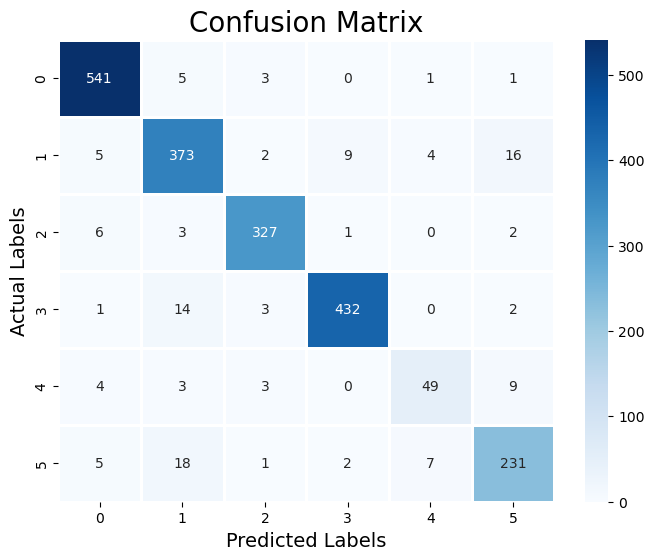

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
# return (y_test, prediction)
print(classification_report(y_test, y_pred))
f1 = f1_score(y_true = y_test, y_pred = y_pred, labels = labels, average = 'micro')

print('F1-score: ',f1*100,'%')

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       551
           1       0.90      0.91      0.90       409
           2       0.96      0.96      0.96       339
           3       0.97      0.96      0.96       452
           4       0.80      0.72      0.76        68
           5       0.89      0.88      0.88       264

    accuracy                           0.94      2083
   macro avg       0.91      0.90      0.91      2083
weighted avg       0.94      0.94      0.94      2083

F1-score:  93.75900144023043 %


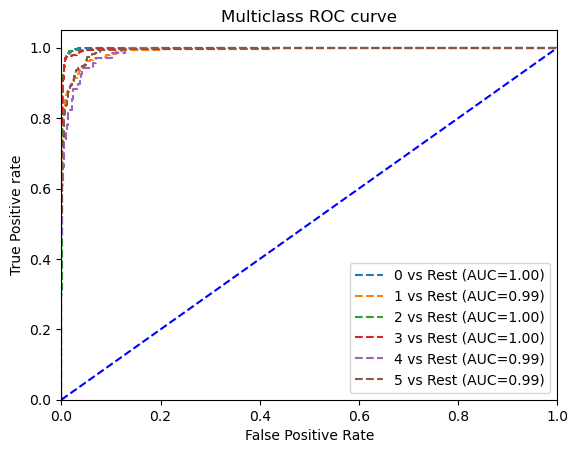

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc
pred_prob = pred_proba
from sklearn.preprocessing import label_binarize
#binarize the y_values

classes = np.unique(y_test)
y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

# n_class = len(labels)

for i in range(len(classes)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_prob,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.938,0.914,0.902,0.907,0.995


In [36]:
import sys

with open(outputFilename, 'a') as f:
    print('XGBoost-w2v,{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc), file=f)

## With Infersent Embedding

In [37]:
X = pd.read_csv(path+'kolkata_infercent_4096.csv')
# Y = pd.read_csv(path+'kolkata_classLabel_named.csv')
print(X.shape,Y.shape)

(8329, 4096) (8329, 1)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['label'])
print(X_train.shape, X_test.shape)

(6246, 4096) (2083, 4096)


In [39]:
model = XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [40]:
y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
pred_proba

array([[1.6352836e-04, 8.2667073e-05, 9.9932492e-01, 7.2856019e-05,
        9.7948221e-05, 2.5814312e-04],
       [8.1438804e-05, 9.9965119e-01, 2.2625038e-04, 1.7443761e-05,
        9.2982209e-06, 1.4397796e-05],
       [2.1358510e-05, 5.0477014e-04, 9.9935502e-01, 3.3641252e-05,
        1.3724766e-05, 7.1479277e-05],
       ...,
       [1.2255634e-02, 3.4856033e-01, 2.5348440e-01, 1.5013210e-02,
        3.7908168e-03, 3.6689565e-01],
       [1.4324089e-04, 1.8893235e-03, 1.2004758e-04, 3.3246339e-04,
        3.1304057e-04, 9.9720192e-01],
       [6.1412957e-03, 6.7559548e-02, 3.8681689e-03, 1.4321613e-02,
        7.9920044e-04, 9.0731019e-01]], dtype=float32)

In [41]:
# return (y_test, prediction)
print(classification_report(y_test, y_pred))
f1 = f1_score(y_true = y_test, y_pred = y_pred, labels = labels, average = 'micro')

print('F1-score: ',f1*100,'%')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       533
           1       0.94      0.94      0.94       444
           2       0.96      0.99      0.97       345
           3       0.99      0.99      0.99       402
           4       0.93      0.79      0.85        66
           5       0.90      0.88      0.89       293

    accuracy                           0.96      2083
   macro avg       0.95      0.93      0.94      2083
weighted avg       0.96      0.96      0.96      2083

F1-score:  95.7753240518483 %


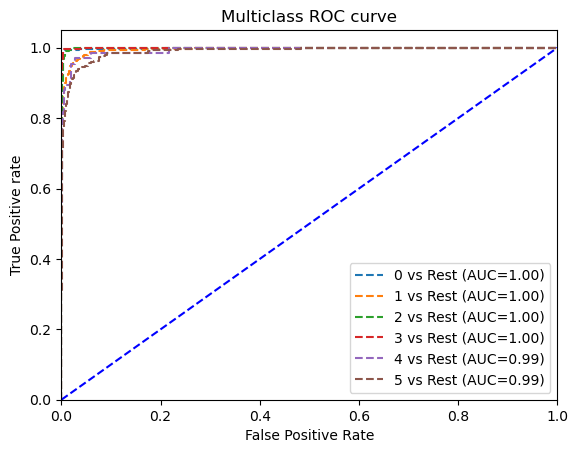

In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc
pred_prob = pred_proba
from sklearn.preprocessing import label_binarize
#binarize the y_values

classes = np.unique(y_test)
y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

# n_class = len(labels)

for i in range(len(classes)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [43]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_prob,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.958,0.950,0.930,0.939,0.996


In [44]:
import sys

with open(outputFilename, 'a') as f:
    print('XGBoost-infercent,{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc), file=f)